In [1]:
import wfdb
import pandas as pd
import numpy as np

#configuration variables
#record_number = 6

#record_list= wfdb.get_record_list('mimic3wdb/matched')

#get data of patient 107
#files=list(filter( lambda x : x.startswith('p') and not x.endswith('n'),wfdb.get_record_list('mimic3wdb/matched/'+record_list[record_number])))
record = wfdb.rdrecord('p000107-2121-11-30-20-03', pb_dir='mimic3wdb/matched/' + 'p00/p000107/', channel_names=['II'])

In [2]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize']=(20,10)
signal = record.p_signal
afternan = np.where(np.isnan(signal))[0][-1] + 1
print(afternan)
print(len(signal))
signal = signal[afternan+5000:afternan+10000] 

8243125
11259250


In [3]:
print(signal.shape)

(5000, 1)


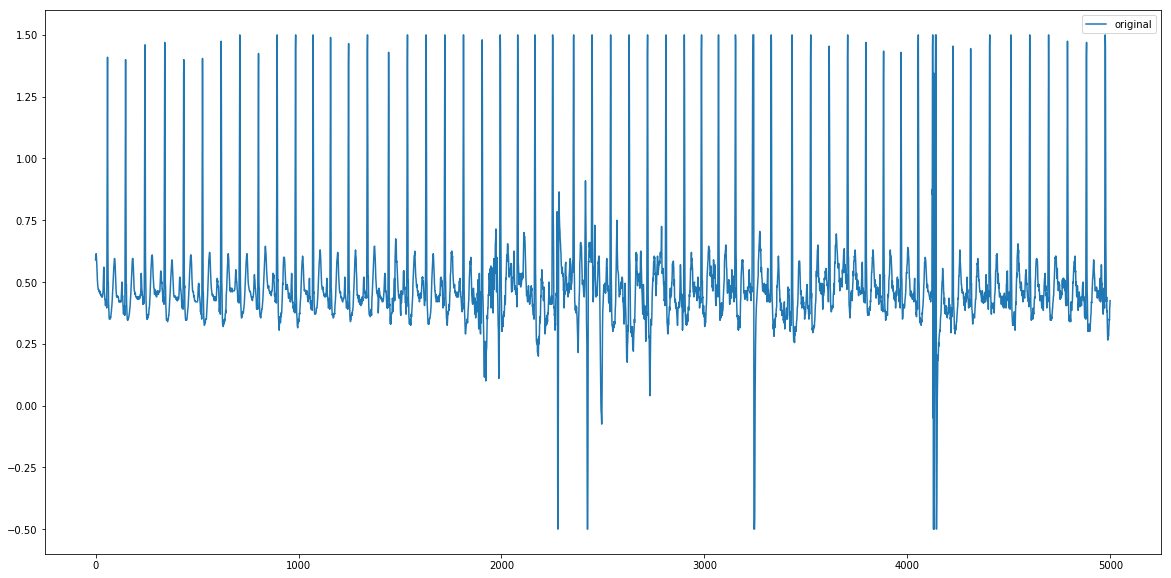

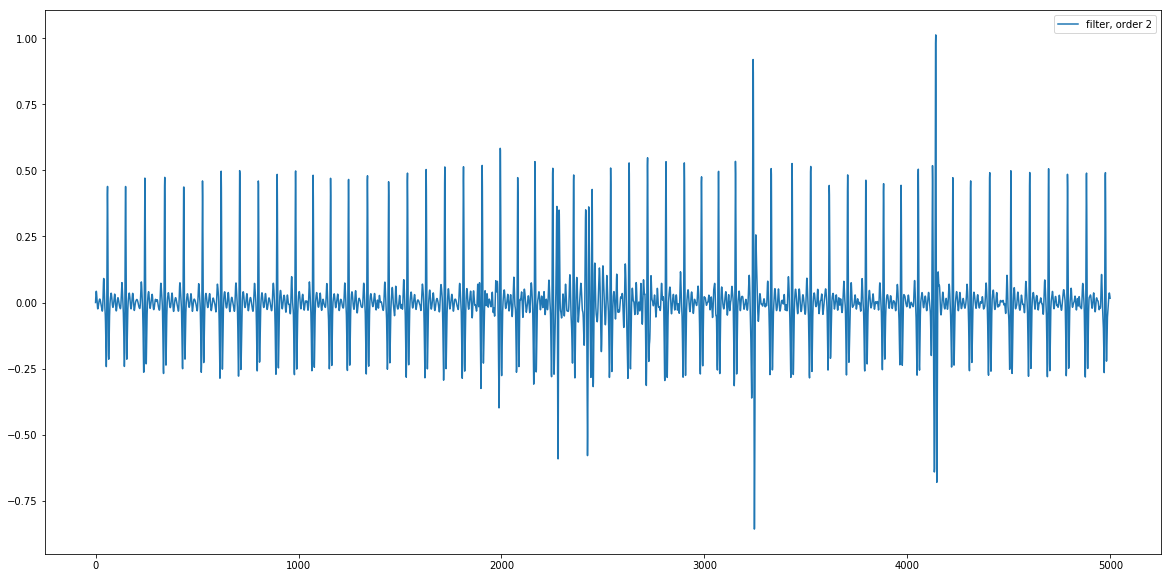

In [25]:
#low-pass filter - cutoff frequencies according to paper IEEE TRANSACTIONS ON BIOMEDICAL ENGINEERING, VOL. BME-32, NO. 3, MARCH 1985
#A Real-Time QRS Detection Algorithm by JIAPU PAN AND WILLIS J. TOMPKINS, 
from scipy.signal import butter, lfilter, filtfilt


def butter_bandpass(lowcut, highcut, fs, order=5):
    #nyq = 0.5 * fs
    low = lowcut *2.0/ fs
    high = highcut *2.0/ fs
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in Hz).
fs = record.fs
lowcut = 5.0
highcut = 15.0


filtered_ecg_6 = butter_bandpass_filter(signal.reshape(-1), lowcut, highcut, fs, order=6)
filtered_ecg_9 = butter_bandpass_filter(signal.reshape(-1), lowcut, highcut, fs, order=9)
#filtered_ecg_3 = butter_bandpass_filter(signal.reshape(-1), lowcut, highcut, fs, order=3)
filtered_ecg_3 = butter_bandpass_filter(signal.reshape(-1), lowcut, highcut, fs, order=2)
plt.plot(signal, label='original')
plt.legend()
plt.show()
plt.plot(filtered_ecg_3, label = 'filter, order 2')
#plt.plot(filtered_ecg_6, label = 'filter, order 6')
#plt.plot(filtered_ecg_9, label = 'filter, order 9')
plt.legend()
plt.show()

In [5]:
print(fs)

125


#Fast Fourier Transform

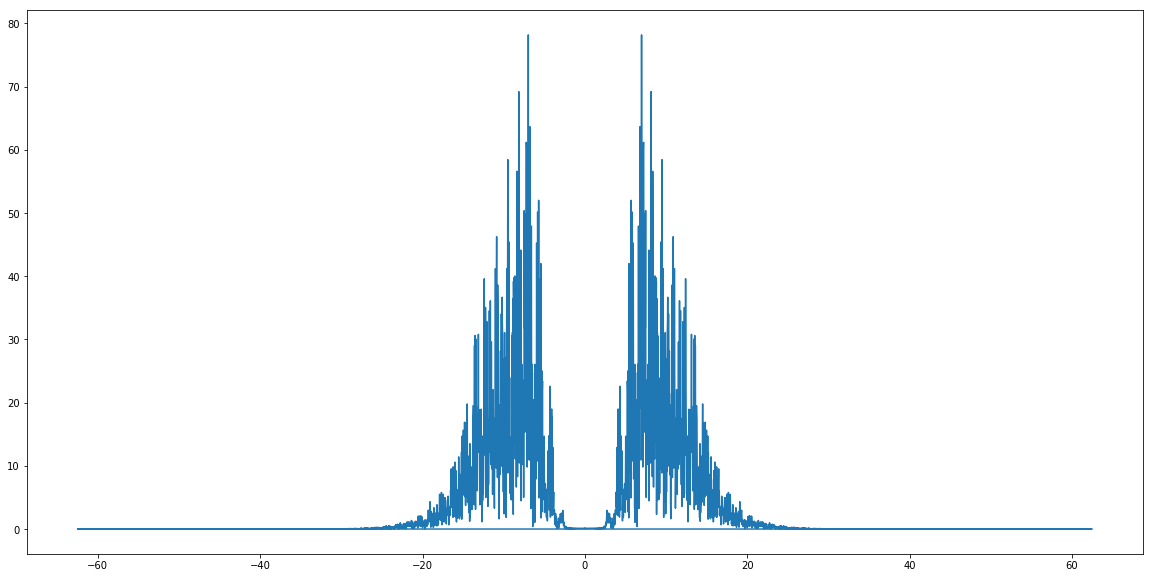

In [26]:
org_fft = np.fft.fft(filtered_ecg_3.reshape(-1))
freq = np.fft.fftfreq(filtered_ecg_3.reshape(-1).size, 1/125.)
plt.plot(freq, np.abs(org_fft))

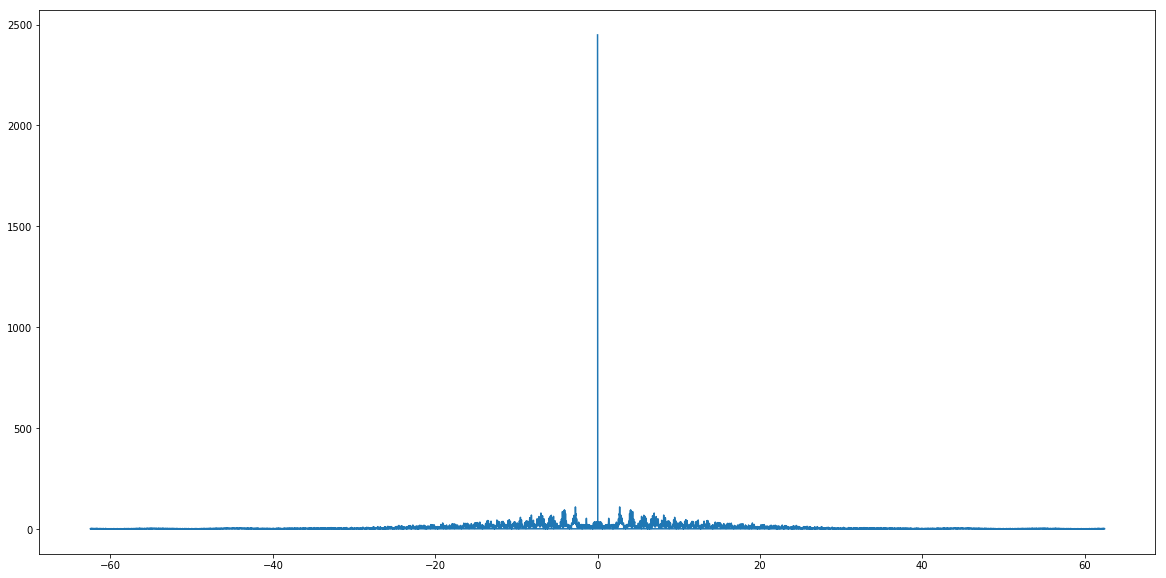

In [7]:
#Of original signal
org_fft = np.fft.fft(signal.reshape(-1))
freq = np.fft.fftfreq(signal.reshape(-1).size, 1/125.)
plt.plot(freq, np.abs(org_fft))


In [8]:
from wfdb import processing



In [40]:
#Create the object to detect pqrs peaks
xqrs = processing.XQRS(signal.reshape(-1), fs, conf=None)

#Detect based on the object 
#detect(sampfrom=0, sampto='end', learn=True, verbose=True)
qrs_inds=xqrs.detect()

#NOte: to detect without object wfdb.processing.xqrs_detect(sig, fs, sampfrom=0, sampto='end', conf=None, learn=True, verbose=True)
#wfdb.plot_items(signal=signal.reshape(-1), ann_samp=[xqrs.qrs_inds])

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


/Users/paula/software/anaconda/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/paula/software/anaconda/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/paula/software/anaconda/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` i

In [41]:
qrs_locs_2 = processing.gqrs_detect(filtered_ecg_3.reshape(-1),fs=125)


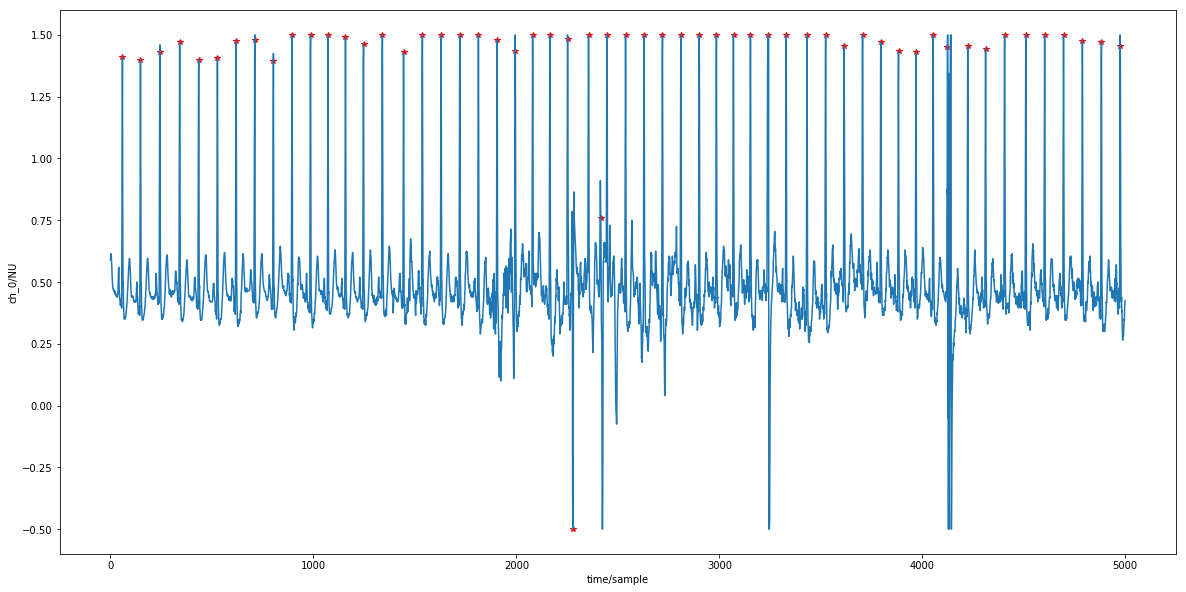

In [42]:
wfdb.plot_items(signal=signal.reshape(-1), ann_samp=[xqrs.qrs_inds])


In [38]:
from oct2py import octave
octave.addpath('matlab')
octave.eval('pkg load signal')

def plot_detection_data(signal, R, Q, S, T, qrs_inds):
    """
    Method responsible for plotting detection results.
    :param bool show_plot: flag for plotting the results and showing plot
    """

    def plot_data(axis, data, title='', fontsize=10):
        axis.set_title(title, fontsize=fontsize)
        axis.grid(which='both', axis='both', linestyle='--')
        axis.plot(data, color="salmon", zorder=1)

    def plot_points(axis, values, indices, c):
        axis.scatter(x=indices, y=values[indices], c=c, s=50, zorder=2)

    plt.close('all')
    fig, axarr = plt.subplots(2, sharex=True, figsize=(15, 18))

    plot_data(axis=axarr[0], data=signal, title='Raw ECG measurements')
    plot_points(axis=axarr[0], values=signal, indices=R, c="red")
    plot_points(axis=axarr[0], values=signal, indices=Q, c="green")
    plot_points(axis=axarr[0], values=signal, indices=S, c="blue")
    plot_points(axis=axarr[0], values=signal, indices=T, c="black")
    plot_data(axis=axarr[1], data=signal, title='QRS_inds')
    plot_points(axis=axarr[1], values=signal, indices=qrs_inds, c="black")

    plt.tight_layout()
    plt.show()


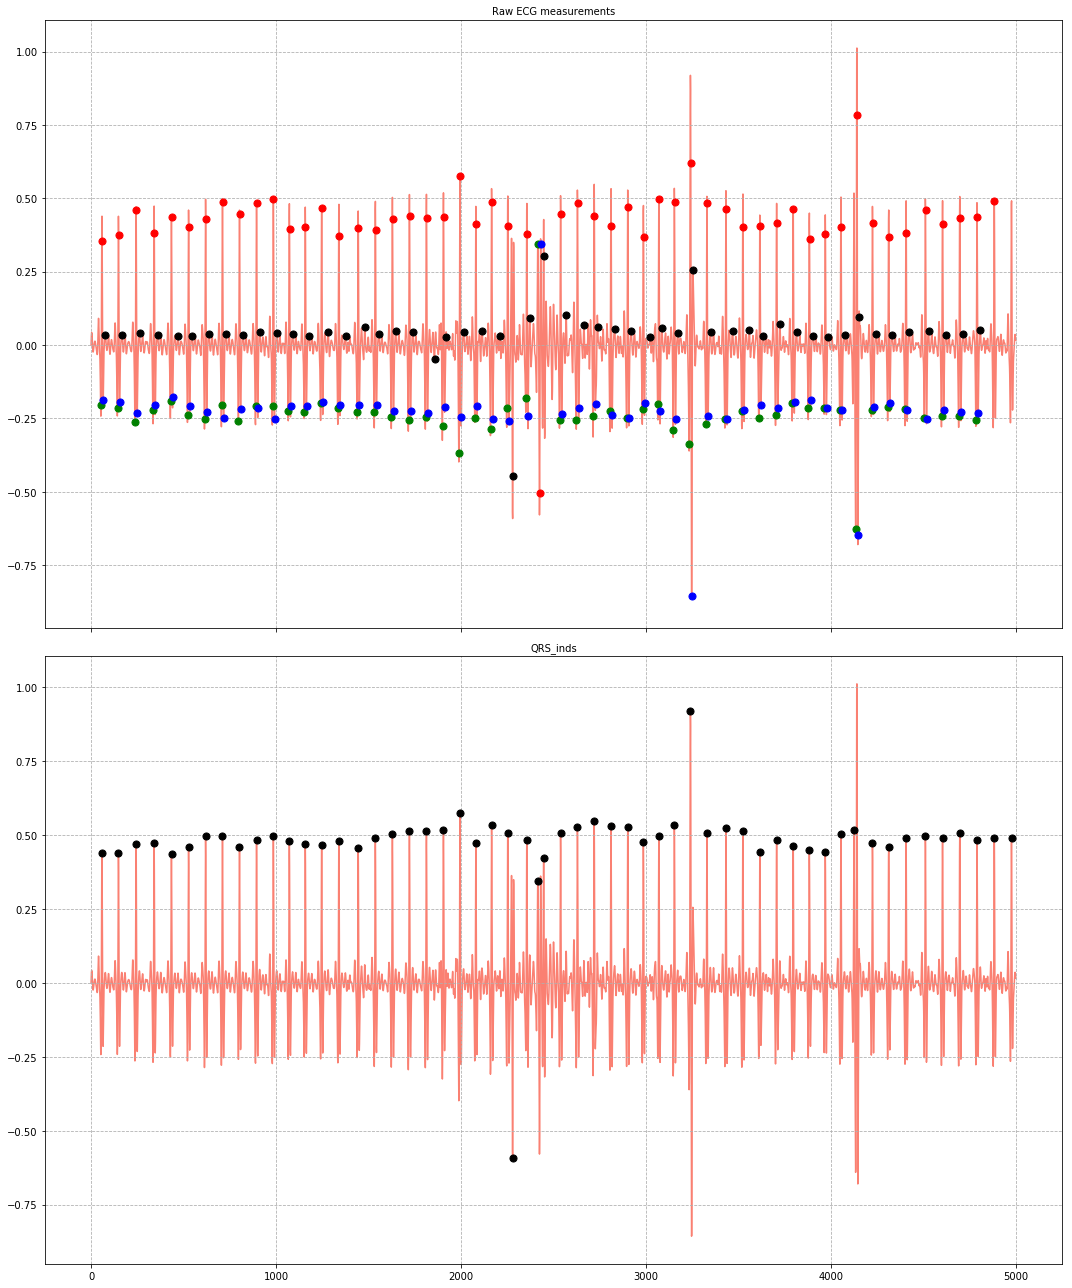

In [43]:
R, Q, S, T, P_w = octave.MTEO_qrst(filtered_ecg_3, 125, False, nout=5, verbose=True)

R = R[:, 0].astype(int)
Q = Q[:, 0].astype(int)
S = S[:, 0].astype(int)
T = T[:, 0].astype(int)
plot_detection_data(filtered_ecg_3, R, Q, S, T, xqrs.qrs_inds)

In [44]:
print(R)

[  60  149  244  342  435  528  620  711  803  895  986 1073 1159 1247
 1341 1445 1538 1630 1722 1814 1906 1995 2081 2166 2254 2357 2425 2539
 2630 2721 2812 2902 2987 3070 3154 3242 3330 3433 3525 3616 3707 3796
 3884 3970 4055 4141 4225 4313 4407 4511 4604 4697 4790 4883]


In [45]:
print(Q)

[  54  143  238  336  430  522  614  706  797  890  981 1067 1153 1242
 1335 1439 1532 1624 1716 1808 1900 1989 2075 2160 2248 2351 2416 2533
 2624 2715 2806 2896 2981 3065 3148 3234 3324 3427 3519 3610 3701 3791
 3878 3964 4049 4134 4219 4307 4401 4505 4598 4691 4784]


In [46]:
print(S)

[  66  155  250  348  442  534  626  717  809  902  992 1079 1165 1254
 1347 1451 1544 1636 1728 1820 1912 2002 2087 2172 2260 2363 2431 2545
 2637 2727 2818 2908 2993 3077 3160 3247 3336 3439 3531 3622 3713 3803
 3890 3976 4061 4146 4231 4319 4413 4517 4610 4703 4796]


In [52]:
print(filtered_ecg_3[R[26]])
print(filtered_ecg_3[Q[26]])
print(filtered_ecg_3[S[26]])
print(filtered_ecg_3[T[26]])

-0.5034533925492986
0.34506679830662884
0.34584557280180345
0.30439441671231665
